# Segmentation Tasks

This notebook contain the code for segmenting and predicting the test data provided by the lecturer.

Cell 5 contains functions that I made to speed up segmentation testing and development. They build on cv2's functions but add some more thresholds for specific things like width height ratio to enable me to remove more noise from images. Please look through these functions as I use them throughout the notebook.

The first section "basic images" processes and outputs the predictions for the first 10 images. These are labelled as basic as they require little processing before the model can predict the numbers correctly.

The sections after that go over each of the more advanced images in order. The sections show all the steps of segmentation to get to the end result and all crucial steps are shown using matplotlib so be sure to scroll through the outputs of the cells to see all the steps aswell as the result.

The final section showcases the method used for segmenting the video frames using a similar format to the image sections. I showcase the segmentation method visualising every 15 frames of the video using matplotlib. The final cell of code runs each frame though a non visual version of the frame segmentation function which is saved to an output video within the assignment folder.

Please use colab for this and change the usingColab boolean to true to load the colab model as it works with the segmentation images. You need to change the cd path to point to he assighnment folder aswell.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

usingColab = True

modelName = "localBest"

In [2]:
if usingColab:
  modelName = "best"
  from google.colab.patches import cv_imshow
  from google.colab import drive
  drive.mount('/content/drive')
  # IMPORTANT - Please change this path to point to the folder of my assignment which you downloaded
  # E.g: /content/drive/MyDrive/pathtoassignment/Assignment
  # It is important there is no / at the end of the path so the model can load correctly
  %cd /content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Machine Learning and Computer Vision/Assginment

Mounted at /content/drive
/content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Machine Learning and Computer Vision/Assginment


In [3]:
# Load CNN model to predict images labels
with open(f"./Models/CNN/{modelName}.pkl", "rb") as f:
  model = pickle.load(f)

In [4]:
# Load test images
numberTestFilePaths = glob.glob("./Number_Test_Data/*.png")

images = [cv2.imread(path) for path in sorted(numberTestFilePaths)]

# Basic images are the images already formatted that can be passed to the model straight away
basicImages = images[:10]

# Segment images are the images that need processing before the model predicts to get an accurate result
segmentImages = images[10:]

In [5]:
def BGR2GRAY(image):
  # Converts input image from BGR (blue green red) to GRAYscale
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def BitwiseImage(image, blackThreshold):
  # Return a bitwised image. Pixel value are clamped to 0 or 255
  return cv2.threshold(image, blackThreshold, 255, cv2.THRESH_OTSU)[1]

def FindContours(image, lowThresholdRange, upperThresholdRange, lowContourThreshold = 0.0, upperContourThreshold = np.inf):
  # Finds the contours on an image within a certain area threshold
  threshold = cv2.inRange(image, lowThresholdRange, upperThresholdRange)
  contours = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

  returnContours = []
  for contour in contours:
    contourArea = cv2.contourArea(contour)
    if(contourArea >= lowContourThreshold and contourArea <= upperContourThreshold):
      returnContours.append(contour)

  return returnContours

def DisplayContours(image, contours):
  # Plots input contours on input image
  img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR).copy()
  cv2.drawContours(img, contours, -1, (0,255,0), 3)
  plt.imshow(img)
  plt.axis(False)

def FindBoundingBoxes(contours, offset, widthHeightRatioThreshold = 1.0):
  # Finds contours best fitted rectangles and scales them by an offset
  boundingBoxes = []
  for contour in contours:
      rect = cv2.boundingRect(contour)
      x,y,w,h = rect

      x = (x - offset//2)
      y = (y - offset//2)
      w = (w+offset)
      h = (h+offset)

      # If the height width ratio is smaller than 1.0 its probably not a number box so don't process
      if(h / w >= widthHeightRatioThreshold):
        # If the cordinates are off the image (negative) don't process
        if(x >= 0 and y >= 0):
          boundingBoxes.append([x, y, w, h])

  return boundingBoxes

def CropBoundingBoxes(image, boundingBoxes):
  # Crops the bounding boxes from a given image
  segments = []

  for box in boundingBoxes:
    segments.append(image[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])

  return segments

def DisplayBoundingBoxes(image, boundingBoxes, lineThickness = 5):
  # Displays bounding boxes on a given image
  imageWithBoxes = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
  for boxCord in boundingBoxes:
    x, y, w, h = boxCord
    cv2.rectangle(imageWithBoxes, (x,y), (x+w, y+h), (0,255,0), lineThickness)

  plt.imshow(imageWithBoxes)
  plt.axis(False)

def MorphImage(image, kernalSize=1, morphFunction=cv2.MORPH_DILATE, iterations=0):
  # Changes a given image based on input morph function, kernal size and iterations
  kernel = np.ones((kernalSize, kernalSize), np.uint16)
  return cv2.morphologyEx(image, morphFunction, kernel, iterations=iterations)

def MakeImageSquareAndResize(image, offset = 0):
  # Makes an image square by adding black padding to the width or height
  # The offset allows custom padding to be added to the images
  shape = np.shape(image)
  diff = (shape[0] - shape[1]) // 2

  if diff < 0:
    diff = np.abs(diff)
    image = cv2.copyMakeBorder(image, diff + offset, diff + offset, offset, offset, cv2.BORDER_CONSTANT)
  else:
    image = cv2.copyMakeBorder(image, offset, offset, diff + offset, diff + offset, cv2.BORDER_CONSTANT)

  # Resizes the image to fit with the model's input shape
  return cv2.resize(image, (28, 28))

def PredictImages(images, model):
  # Passes an array of images to the model to predict and returns the predictions and confidences of those predictions

  results = model.predict(images, verbose=None)

  predictions = np.argmax(results, axis=1)
  confidences = np.max(results, axis=1)

  return predictions, confidences

def DrawPredictions(image, predictions, boundingBoxes, confidences, confidenceThreshold= 0.0, lineThickness = 5, fontThickness = 1, fontSize = 1):
  # Return an image with the drawn bounding boxes and prediction labels for those boxes

  imageWithPredictions = image.copy()

  for prediction, confidence, boundingBox in zip(predictions, confidences, boundingBoxes):
    if(confidence >= confidenceThreshold):

      x, y, w, h = boundingBox
      cv2.rectangle(imageWithPredictions, (x,y), (x+w, y+h), (0,255,0), lineThickness)

      cv2.putText(imageWithPredictions, str(prediction), (x,y+10), cv2.FONT_HERSHEY_SIMPLEX, fontSize, (255,0,0), fontThickness, cv2.LINE_AA)

  return imageWithPredictions

## Basic Images

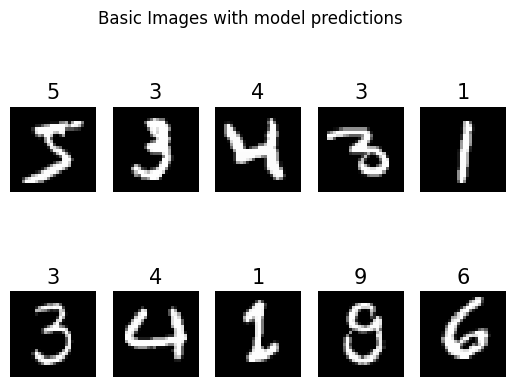

In [6]:
# Convert images to grayscale
basicImagesGray = [BGR2GRAY(image) for image in basicImages]
basicImagesSquare = [MakeImageSquareAndResize(image) for image in basicImagesGray]

# Predict the label of the image using CNN model
basicImagePredictions, basicImageConfidences = PredictImages(np.array(basicImagesSquare), model)

# Show output labels of the model
fig, axes = plt.subplots(2, 5)
fig.suptitle("Basic Images with model predictions")

plt.subplots_adjust(wspace=0.2, hspace=0)

for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(basicImagesGray[i*5+j], cmap='gray')
    ax.set_title(basicImagePredictions[i*5+j], fontsize=15)
    ax.axis(False)

##Image 1

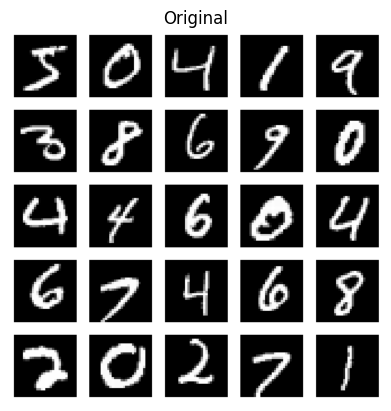

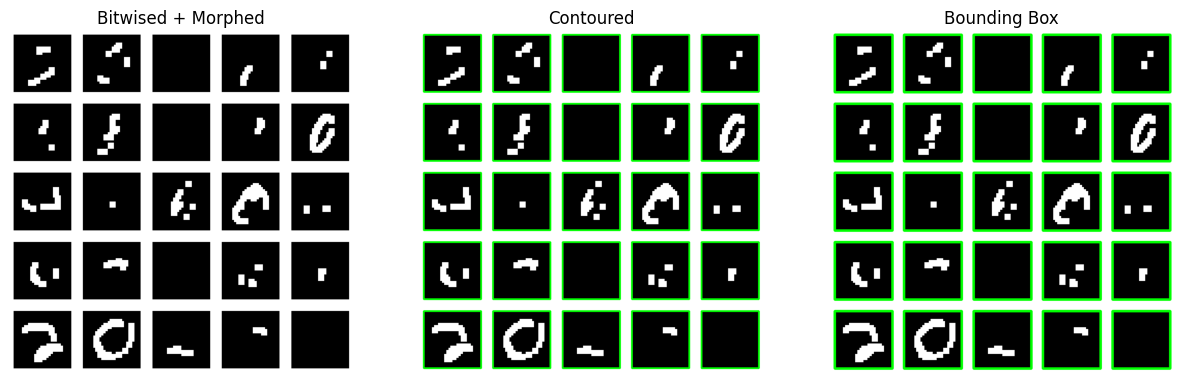

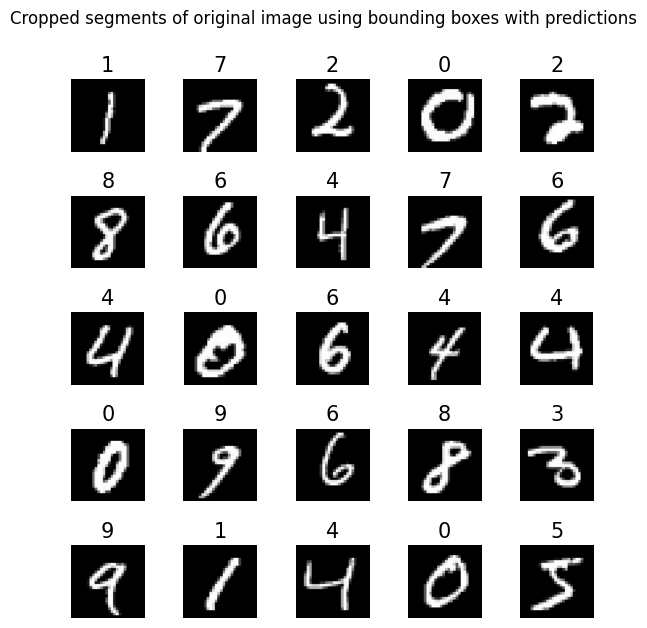

In [7]:
# Getting the first segmented Image and grayscaling it
image1 = segmentImages[0]
image1 = BGR2GRAY(image1)

# Clamp values to either 0 or 255 based on a threshold (10 in this case)
image1Bitwised = BitwiseImage(image1, 10)

# Apply the open morphology method which slowly reduces white blobs
image1Morphed = MorphImage(image1Bitwised, 3, cv2.MORPH_OPEN, 6)

# Find contours of black sections of the image
image1Contours = FindContours(image1Morphed, 0, 10)

# Draw 4 points rectangles round the contours for simpler segmentation
image1BoundingBoxes = FindBoundingBoxes(image1Contours, 0, 0.0)

# Segment the image using the points of the boxes to crop
image1Segments = CropBoundingBoxes(image1, image1BoundingBoxes)

# Adjust image to be square and resize to 28 x 28
image1SegmentsSquare = [MakeImageSquareAndResize(image) for image in image1Segments]

# Get model predictions for segments
image1Predictions, image1Confidences = PredictImages(np.array(image1SegmentsSquare), model)

# Displaying the different images at each stage of processing
plt.imshow(image1, cmap='gray')
plt.axis(False)
plt.title("Original")

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

s1 = fig.add_subplot(1,3,1)
s1.imshow(image1Morphed, cmap='gray')
s1.axis(False)
s1.set_title("Bitwised + Morphed")

s2 = fig.add_subplot(1,3,2)
s2.set_title("Contoured")
DisplayContours(image1Morphed, image1Contours)

s3 = fig.add_subplot(1,3,3)
s3.set_title("Bounding Box")
DisplayBoundingBoxes(image1Morphed, image1BoundingBoxes)

fig, axes = plt.subplots(5, 5, figsize=(7, 7))
fig.suptitle("Cropped segments of original image using bounding boxes with predictions")
plt.subplots_adjust(hspace=0.6)
for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(image1Segments[i*5+j], cmap='gray')
    ax.set_title(image1Predictions[i*5+j], fontsize=15)
    ax.axis(False)

##Image 2

(-0.5, 391.5, 238.5, -0.5)

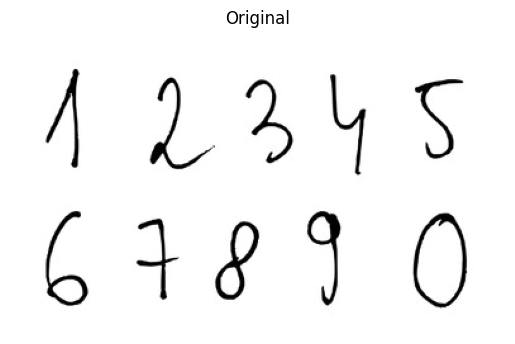

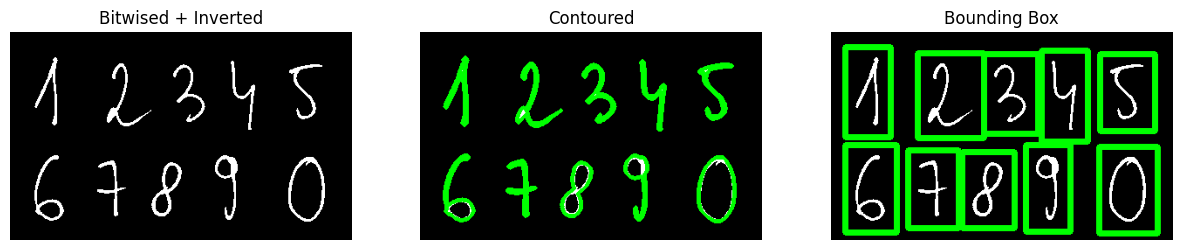

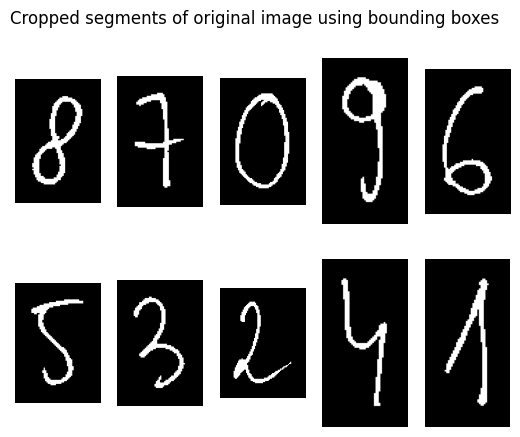

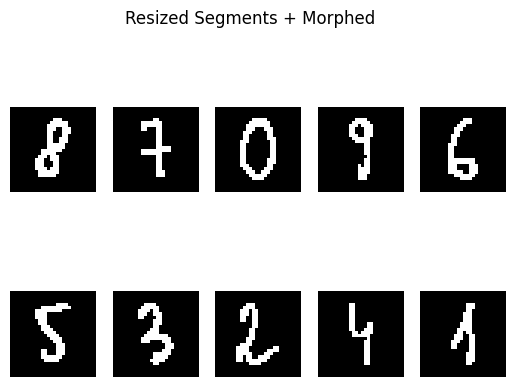

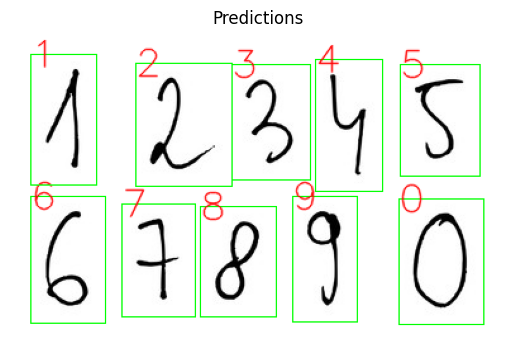

In [9]:
# Get second image and grayscale it
image2 = segmentImages[1]
image2Gray = BGR2GRAY(image2)

# Clamp values in image to 0 or 255 with threshold 10
image2Bitwised = BitwiseImage(image2Gray, 10)

# changes values 0 - 255 and 255 - 0 so output is same as mnist
image2Inverted = cv2.bitwise_not(image2Bitwised)

# Find contours within the colour range 0 - 10 (black)
image2Contours = FindContours(image2Inverted, 250, 255)

# Fit bounding box to contour
image2BoundingBoxes = FindBoundingBoxes(image2Contours, 25)

# Crop original image using bounding box as crop boundary
image2Segments = CropBoundingBoxes(image2Inverted, image2BoundingBoxes)

# Morph segments to make numbers fuller and more visible
image2SegmentsMorphed = [MorphImage(image, 3, cv2.MORPH_DILATE, 2) for image in image2Segments]

# Make segments square and resize to 28, 28
image2SegmentsSquare = [MakeImageSquareAndResize(image, 5) for image in image2SegmentsMorphed]

# Bitwise each segments so it is only black and white no gray
image2SegmentsSquareBitwised = [BitwiseImage(image, 50) for image in image2SegmentsSquare]

# Get model predictions for segments
image2Predictions, image2Confidences = PredictImages(np.array(image2SegmentsSquareBitwised), model)

# Draws the predicted labels with bounding boxes to the image
image2WithPredictions = DrawPredictions(image2, image2Predictions, image2BoundingBoxes, image2Confidences, 0.0, lineThickness=1, fontThickness=1)

# Displaying the different images at each stage of processing
plt.imshow(image2Gray, cmap='gray')
plt.axis(False)
plt.title("Original")

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

s1 = fig.add_subplot(1,3,1)
s1.imshow(image2Inverted, cmap='gray')
s1.axis(False)
s1.set_title("Bitwised + Inverted")

s2 = fig.add_subplot(1,3,2)
s2.set_title("Contoured")
DisplayContours(image2Inverted, image2Contours)

s3 = fig.add_subplot(1,3,3)
s3.set_title("Bounding Box")
DisplayBoundingBoxes(image2Inverted, image2BoundingBoxes)

fig, axes = plt.subplots(2, 5)
fig.suptitle("Cropped segments of original image using bounding boxes")
for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(image2Segments[i*5+j], cmap='gray')
    ax.axis(False)

fig, axes = plt.subplots(2, 5)
fig.suptitle("Resized Segments + Morphed")
plt.subplots_adjust(wspace=0.2, hspace=0)
for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(image2SegmentsSquareBitwised[i*5+j], cmap='gray')
    ax.axis(False)

plt.figure()

plt.title("Predictions")
plt.imshow(image2WithPredictions)
plt.axis(False)

##Image 3

(-0.5, 4031.5, 3023.5, -0.5)

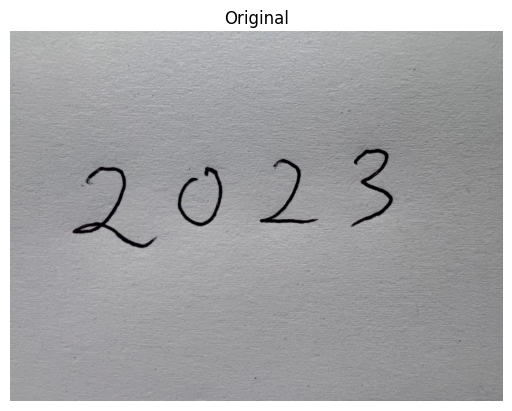

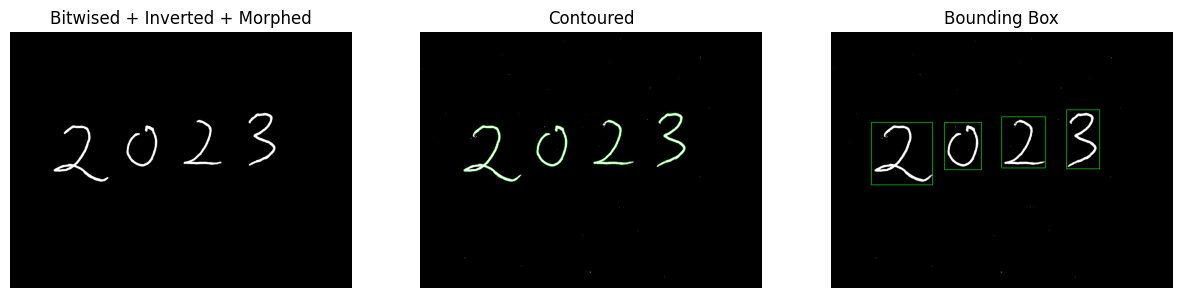

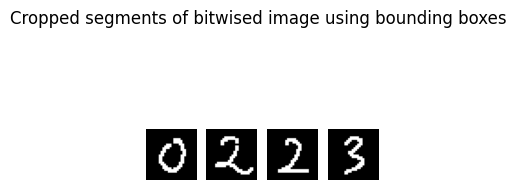

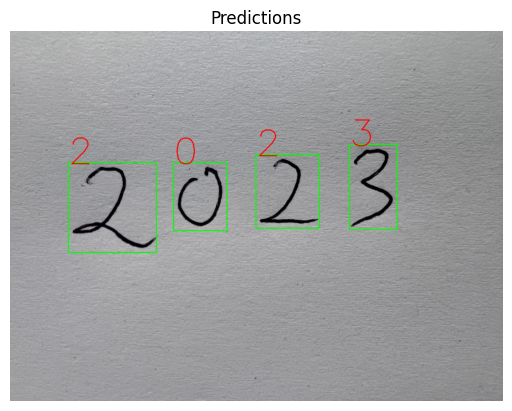

In [10]:
image3 = segmentImages[2]

# Grayscale image
image3Gray = BGR2GRAY(image3)

# Bitwise image so it is only black and white not gray
image3Bitwised = BitwiseImage(image3Gray, 10)

# Invert the image so black is white and white is black
image3Inverted = cv2.bitwise_not(image3Bitwised)

# Open the image to remove small noise from the image
image3Morphed = MorphImage(image3Inverted, 3, cv2.MORPH_OPEN, 8)

# Find contours of white sections on the image
image3Contours = FindContours(image3Morphed, 250, 255)

# Draw fitted bounding boxes found the contours
image3BoundingBoxes = FindBoundingBoxes(image3Contours, 75)

# Crop these bounding boxes out of the inverted image
image3Segments = CropBoundingBoxes(image3Inverted, image3BoundingBoxes)

# Make segments square and resize to 28 x 28
image3SegmentsSquare = [MakeImageSquareAndResize(image, 100) for image in image3Segments]

# Make sure segments are only black and white
image3SegmentsSquareBitwised = [cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1] for image in image3SegmentsSquare]

# Morph segments to make numbers more visible
image3SegmentsSquareMorphed = [MorphImage(image, 2, cv2.MORPH_DILATE, 1) for image in image3SegmentsSquareBitwised]

# Get label predicions for each segment
image3Predictions, image3Confidences = PredictImages(np.array(image3SegmentsSquareMorphed), model)

# Draws the predicted labels with bounding boxes to the image
image3WithPredictions = DrawPredictions(image3, image3Predictions, image3BoundingBoxes, image3Confidences, 0.0, lineThickness=8, fontThickness=8, fontSize=10)

# Displaying the different images at each stage of processing
plt.imshow(image3, cmap='gray')
plt.axis(False)
plt.title("Original")

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

s1 = fig.add_subplot(1,3,1)
s1.imshow(image3Morphed, cmap='gray')
s1.axis(False)
s1.set_title("Bitwised + Inverted + Morphed")

s2 = fig.add_subplot(1,3,2)
s2.set_title("Contoured")
DisplayContours(image3Inverted, image3Contours)

s3 = fig.add_subplot(1,3,3)
s3.set_title("Bounding Box")
DisplayBoundingBoxes(image3Inverted, image3BoundingBoxes)

fig, axes = plt.subplots(1, 4, figsize=(3, 3))
fig.suptitle("Cropped segments of bitwised image using bounding boxes")
for i, ax in enumerate(axes):
  ax.imshow(image3SegmentsSquareMorphed[i], cmap='gray')
  ax.axis(False)

plt.figure()

plt.title("Predictions")
plt.imshow(image3WithPredictions)
plt.axis(False)

## Image 4

(-0.5, 4031.5, 3023.5, -0.5)

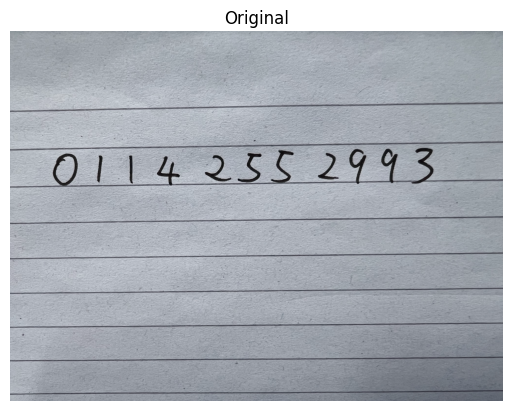

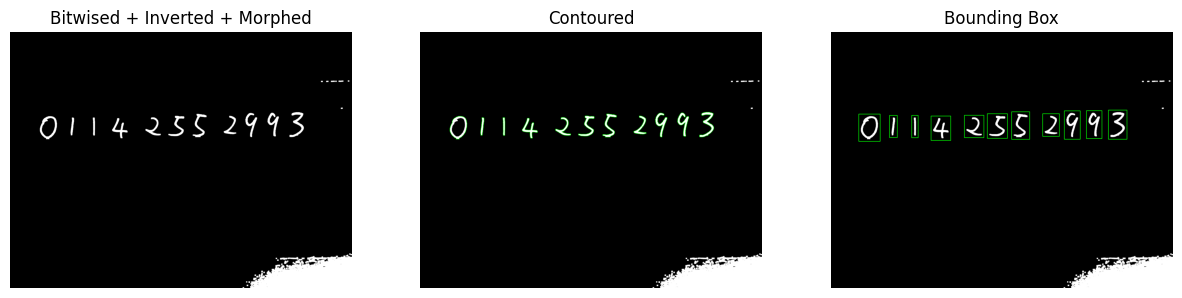

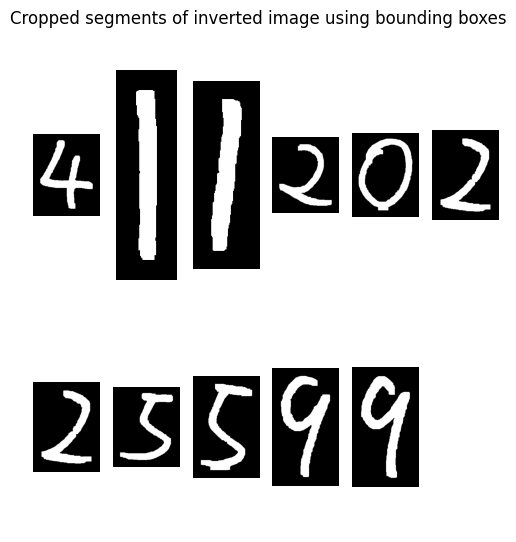

<Figure size 640x480 with 0 Axes>

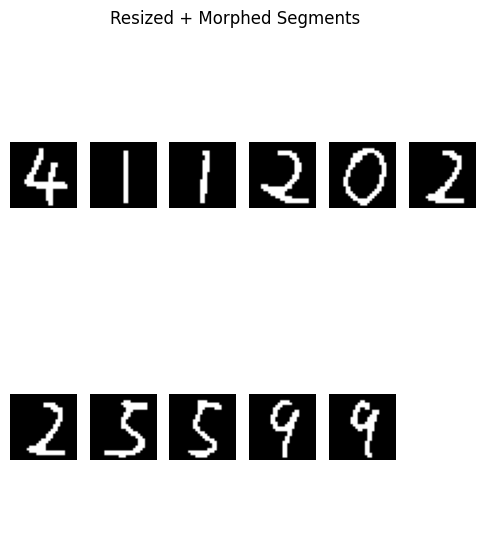

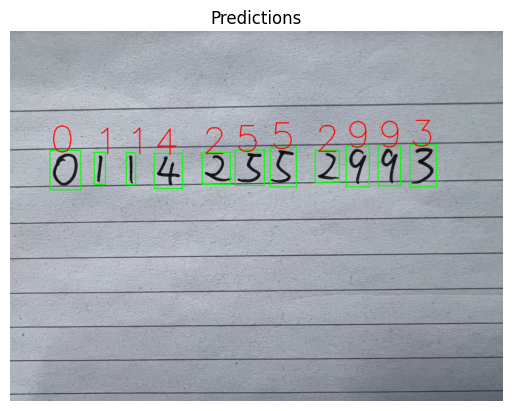

In [12]:
image4 = segmentImages[3]

# Grayscale the image
image4Gray = BGR2GRAY(image4)

# Clamp pixel values to either 0 or 255
image4Bitwised = BitwiseImage(image4Gray, 10)

# Make black pixels white and white pixel black
image4Inverted = cv2.bitwise_not(image4Bitwised)

# Morph the image to remove small noise from the image
image4Morphed = MorphImage(image4Inverted, 3, cv2.MORPH_OPEN, 7)

# Find white contours in the image with a certain area threshold
image4Contours = FindContours(image4Morphed, 250, 255, 3500.0, 42000.0)

# Fit bounding boxes to contours
image4BoundingBoxes = FindBoundingBoxes(image4Contours, 50)

# Crop these bounding boxes using the morphed image to crop from
image4Segments = CropBoundingBoxes(image4Morphed, image4BoundingBoxes)

# Make segments square and resize to 28 x 28
image4SegmentsSquare = [MakeImageSquareAndResize(image) for image in image4Segments]

# Bitwise these images so it is only 0 and 255 pixel values
image4SegmentsSquareBitwised = [cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1] for image in image4SegmentsSquare]

# Morph these segments to make numbers more visible
image4SegmentsSquareMorphed = [MorphImage(image, 2, cv2.MORPH_CLOSE, 1) for image in image4SegmentsSquareBitwised]

# Predict labels for these images
image4Predictions, image4Confidences = PredictImages(np.array(image4SegmentsSquareMorphed), model)

# Draws the predicted labels with bounding boxes to the image
image4WithPredictions = DrawPredictions(image4, image4Predictions, image4BoundingBoxes, image4Confidences, 0.0, lineThickness=8, fontThickness=8, fontSize=10)

# Displaying the different images at each stage of processing
plt.imshow(image4, cmap='gray')
plt.axis(False)
plt.title("Original")

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

s1 = fig.add_subplot(1,3,1)
s1.imshow(image4Morphed, cmap='gray')
s1.axis(False)
s1.set_title("Bitwised + Inverted + Morphed")

s2 = fig.add_subplot(1,3,2)
s2.set_title("Contoured")
DisplayContours(image4Morphed, image4Contours)

s3 = fig.add_subplot(1,3,3)
s3.set_title("Bounding Box")
DisplayBoundingBoxes(image4Morphed, image4BoundingBoxes)

fig, axes = plt.subplots(2, 6, figsize=(6, 6))
fig.suptitle("Cropped segments of inverted image using bounding boxes")

count = 6
for i, row in enumerate(axes):
  for j in range(count):
    row[j].imshow(image4Segments[i*5+j], cmap='gray')
    row[j].axis(False)
  count -= 1

axes[-1][-1].axis(False)

plt.figure()

fig, axes = plt.subplots(2, 6, figsize=(6, 6))
fig.suptitle("Resized + Morphed Segments")

count = 6
for i, row in enumerate(axes):
  for j in range(count):
    row[j].imshow(image4SegmentsSquareMorphed[i*5+j], cmap='gray')
    row[j].axis(False)
  count -= 1

axes[-1][-1].axis(False)

plt.figure()

plt.title("Predictions")
plt.imshow(image4WithPredictions)
plt.axis(False)

##Image 5

(-0.5, 4031.5, 3023.5, -0.5)

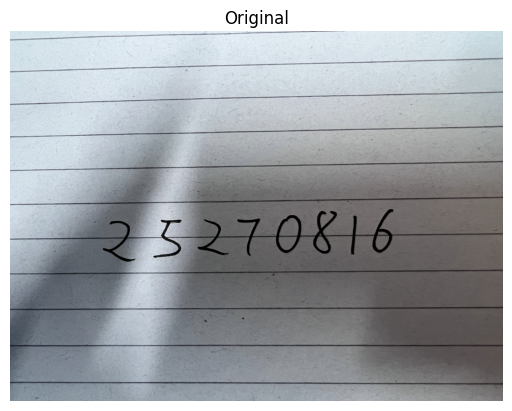

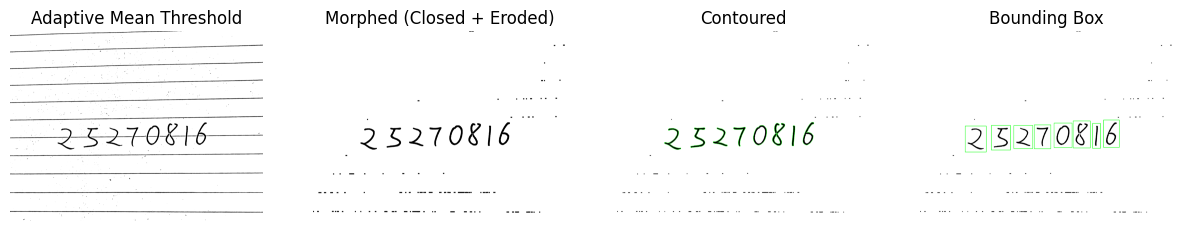

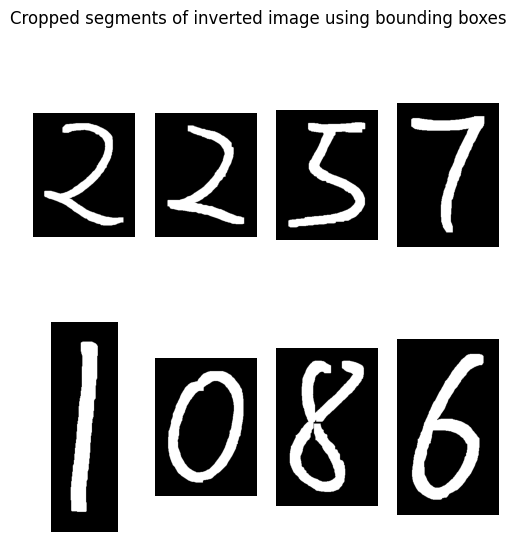

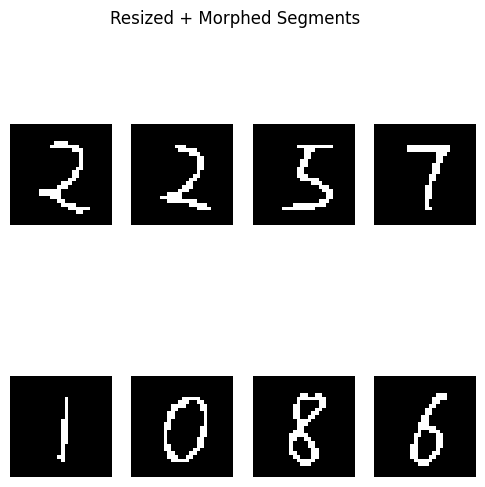

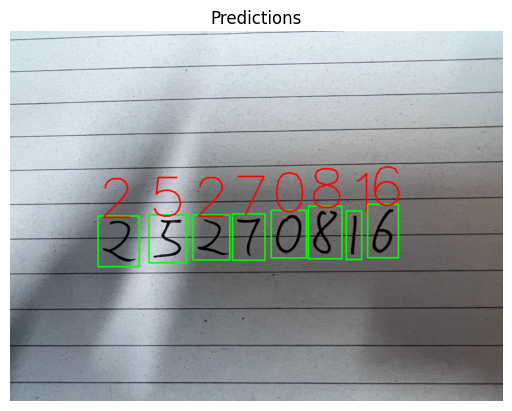

In [13]:
image5 = segmentImages[-1]

# Grayscale image
image5Gray = BGR2GRAY(image5)

# Apply adaptive mean threshold to image to remove large amount of noise
image5MeanThreshold = cv2.adaptiveThreshold(image5Gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 25)

# Remove small amounts of noise from the image
image5MorphedClosed = MorphImage(image5MeanThreshold, 3, cv2.MORPH_CLOSE, 5)

# Enlarge image blobs to make them more distinct
image5MorphedEroded = MorphImage(image5MorphedClosed, 3, cv2.MORPH_ERODE, 3)

# Find contours of black pixels in the image
image5Contours = FindContours(image5MorphedEroded, 0, 10, lowContourThreshold=7500.0)

# Fit bounding boxes to these segments
image5BoundingBoxes = FindBoundingBoxes(image5Contours, 75)

# Clamps pixels to 0 or 255 based on a threshold
image5Bitwised = BitwiseImage(image5MorphedEroded, 10)

# Invert image so black pixels are white and white pixels are black
image5Inverted = cv2.bitwise_not(image5Bitwised)

# Crop these bounding boxes using the inverted image
image5Segments = CropBoundingBoxes(image5Inverted, image5BoundingBoxes)

# Make cropped segments square and resize to 28 x 28
image5SegmentsSquare = [MakeImageSquareAndResize(image, 40) for image in image5Segments]

# Bitwise image again so black is 0 and white is 255
image5SegmentsSquareBitwised = [cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1] for image in image5SegmentsSquare]

# Morph the image so numbers are bigger and more visible in image
image5SegmentsSquareMorphed = [MorphImage(image, 2, cv2.MORPH_CLOSE, 1) for image in image5SegmentsSquareBitwised]

# Predict label for segments
image5Predictions, image5Confidences = PredictImages(np.array(image5SegmentsSquareMorphed), model)

image5WithPredictions = DrawPredictions(image5, image5Predictions, image5BoundingBoxes, image5Confidences, 0.0, lineThickness=12, fontThickness=12, fontSize=15)

# Displaying the different images at each stage of processing
plt.imshow(image5, cmap='gray')
plt.axis(False)
plt.title("Original")

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

s1 = fig.add_subplot(1,4,1)
s1.imshow(image5MeanThreshold, cmap='gray')
s1.axis(False)
s1.set_title("Adaptive Mean Threshold")

s1 = fig.add_subplot(1,4,2)
s1.imshow(image5MorphedEroded, cmap='gray')
s1.axis(False)
s1.set_title("Morphed (Closed + Eroded)")

s2 = fig.add_subplot(1,4,3)
s2.set_title("Contoured")
DisplayContours(image5MorphedClosed, image5Contours)

s3 = fig.add_subplot(1,4,4)
s3.set_title("Bounding Box")
DisplayBoundingBoxes(image5MorphedClosed, image5BoundingBoxes)

fig, axes = plt.subplots(2, 4, figsize=(6, 6))
fig.suptitle("Cropped segments of inverted image using bounding boxes")

for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(image5Segments[i*4+j], cmap="gray")
    ax.axis(False)

fig, axes = plt.subplots(2, 4, figsize=(6, 6))
fig.suptitle("Resized + Morphed Segments")

for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(image5SegmentsSquareMorphed[i*4+j], cmap="gray")
    ax.axis(False)

plt.figure()

plt.title("Predictions")
plt.imshow(image5WithPredictions)
plt.axis(False)

## Video

The first three cells show video as well as the segmentation method used for the video frames. It visualises each major segmentation stage. The other cells after that run a non-visual version of the function below to predict each of the frames in the test video and outputs that to a file. The file is called OutputVideo.avi and should be able to run on windows and if not on google drive.

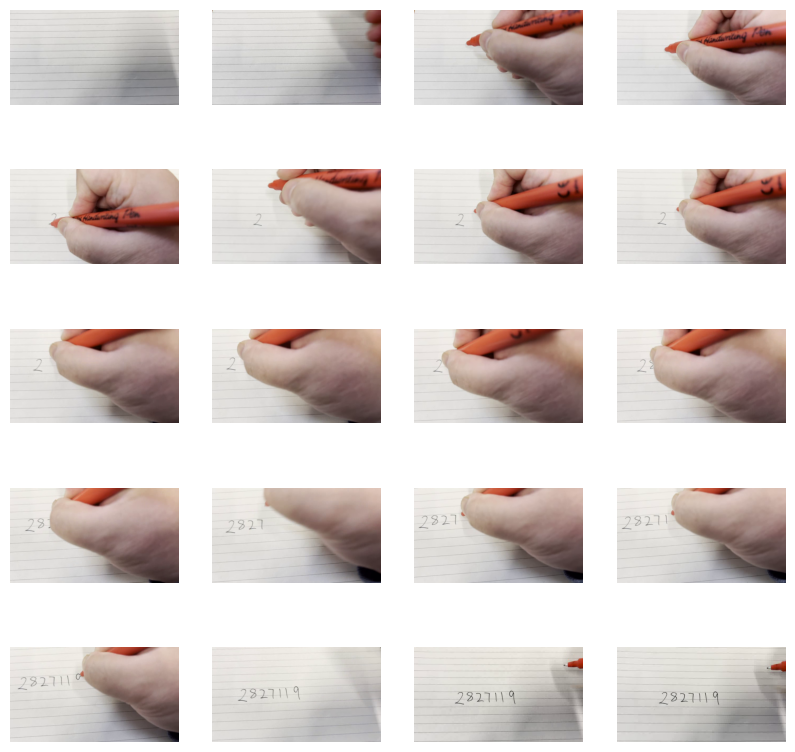

In [ ]:
# Load image and append all frames to an array
vid = cv2.VideoCapture("./Number_Test_Data/015.avi")

frames = []
while True:
  ret, frame = vid.read()

  if(ret == False):
    break

  frames.append(frame)

# Show every 10 frames of the video up to the 200th frame
fig, axes = plt.subplots(5, 4, figsize=(10, 10))

for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(cv2.cvtColor(frames[(i*5)*10 + j*10], cv2.COLOR_BGR2RGB))
    ax.axis(False)

In [ ]:
def ProccessVideoFrameWithVisuals(image):

  # Blurs image to make it easier to remove lines
  frameBlurred = cv2.GaussianBlur(image, (3, 3), 2)

  # Mean shift the image to remove lines and most of noise from the image
  frameMeanShifted = cv2.pyrMeanShiftFiltering(frameBlurred, 9, 20)

  fig = plt.figure()
  fig.set_figheight(15)
  fig.set_figwidth(15)

  s1 = fig.add_subplot(1,5,1)
  s1.imshow(frameMeanShifted, cmap='gray')
  s1.axis(False)
  s1.set_title("Blur + Pyr Mean Shift")

  # Grayscale the image
  frameMeanShiftedG = BGR2GRAY(frameMeanShifted)

  # Apply an adaptive threshold to the image to remove noise
  frameMeanAdaptive = cv2.adaptiveThreshold(frameMeanShiftedG, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 75, 20)

  s2 = fig.add_subplot(1,5,2)
  s2.imshow(frameMeanAdaptive, cmap='gray')
  s2.axis(False)
  s2.set_title("Adaptive Mean Threshold")

  # Find contours of black with an area between 25 and 550
  # This threshold removes big contours that are not numbers
  frameConts = FindContours(frameMeanAdaptive, 0, 10, 25.0, 550.0)

  s3 = fig.add_subplot(1,5,3)
  DisplayContours(frameMeanAdaptive, frameConts)
  s3.set_title("Contours")

  # Fit bounding boxes using contours with an offset of 10
  frameBoundingBoxes = FindBoundingBoxes(frameConts, 10)

  s4 = fig.add_subplot(1,5,4)
  DisplayBoundingBoxes(frameMeanAdaptive, frameBoundingBoxes, 1)
  s4.set_title("Bounding Boxes")

  # Crop bounding boxes from the adaptive image
  frameSegments = CropBoundingBoxes(frameMeanAdaptive, frameBoundingBoxes)

  # Make sure there are bounding boxes to process before attempting it
  if len(frameSegments) < 1:
    return

  # Clamp pixel values to either 0 or 255
  frameSegmentsBitwised = [BitwiseImage(image, 10) for image in frameSegments]

  # Invert white to black and black to white to fit to the mnist dataset style
  frameSegmentsinverted = [cv2.bitwise_not(image) for image in frameSegmentsBitwised]

  # Square and resize image and add 2 pixels worth of padding round the edges
  frameSegmentsSquare = [MakeImageSquareAndResize(image, 2) for image in frameSegmentsinverted]

  # Morph the images to remove potential noise
  frameSegmentsSquareMorphed = [MorphImage(image, 2, cv2.MORPH_CLOSE, 1) for image in frameSegmentsSquare]

  # Predict the labels of the segments
  framePredictions, frameConfidences = PredictImages(np.array(frameSegmentsSquareMorphed), model)

  # Draw the predictions to the image
  frameWithPredictions = DrawPredictions(image, framePredictions, frameBoundingBoxes, frameConfidences, 0.0, lineThickness=1, fontThickness=1, fontSize=1)

  s4 = fig.add_subplot(1,5,5)
  plt.title("Predictions")
  plt.imshow(frameWithPredictions)
  plt.axis(False)

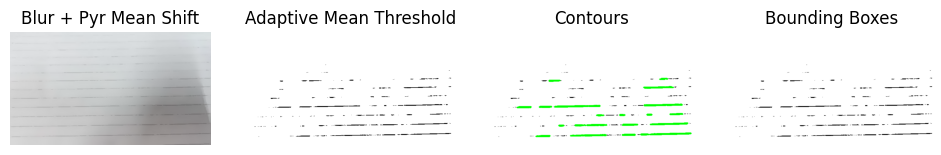

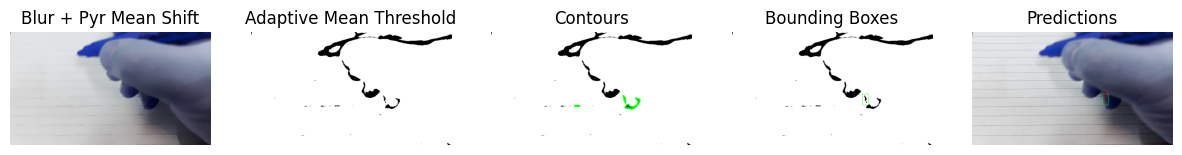

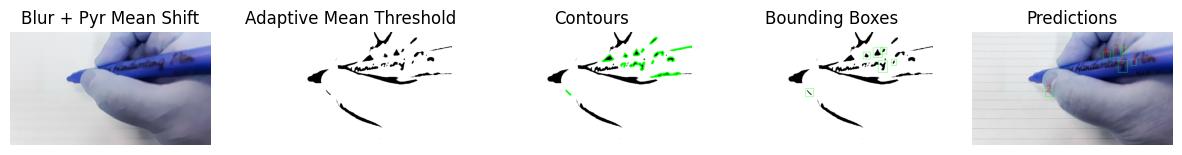

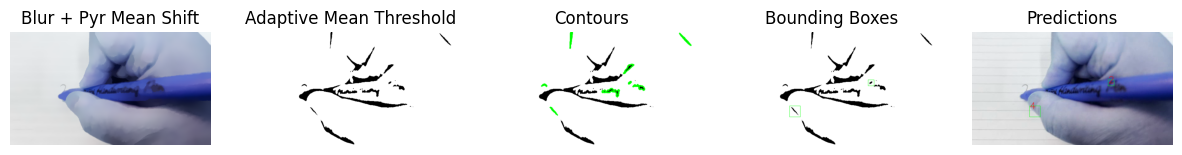

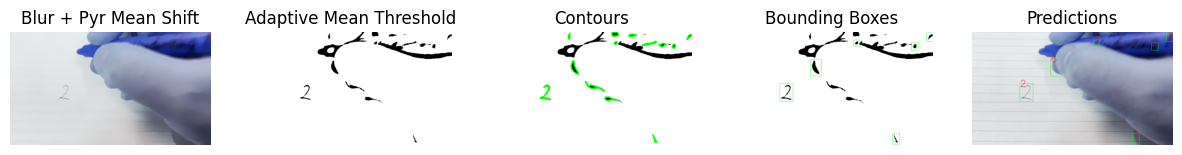

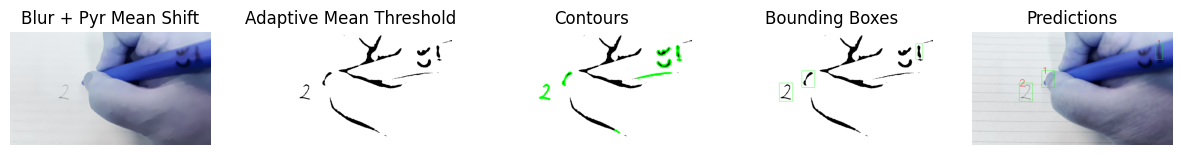

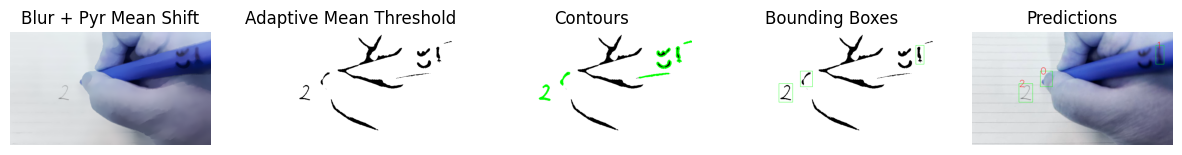

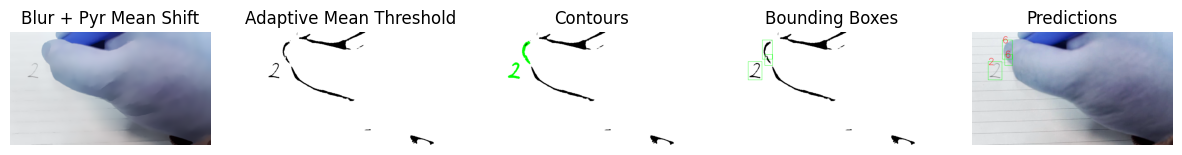

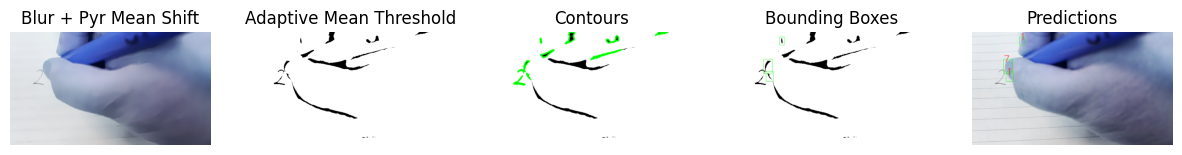

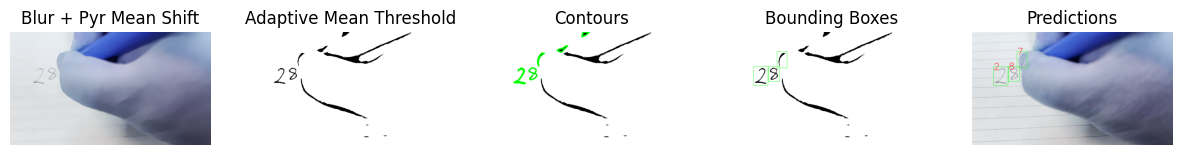

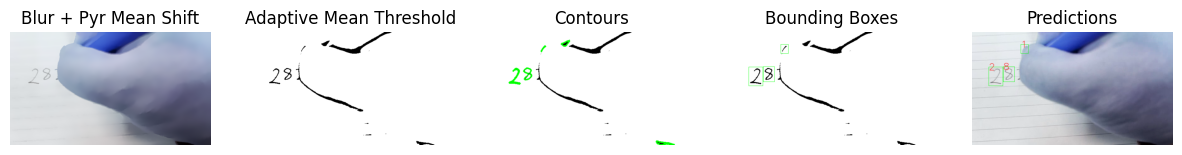

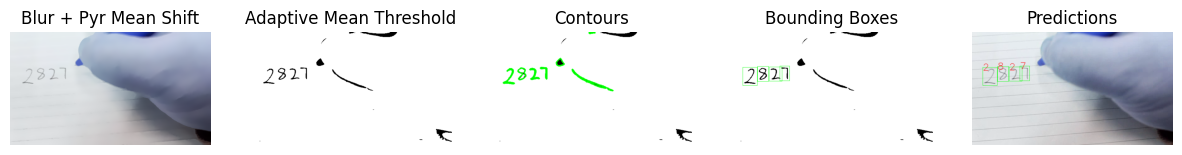

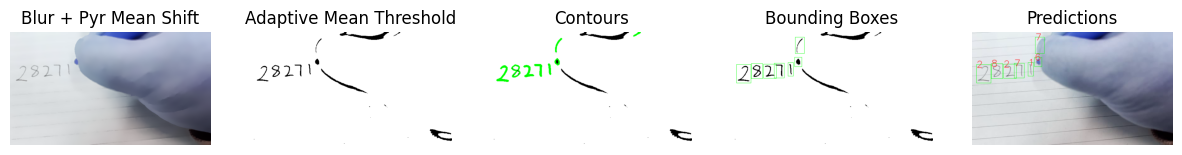

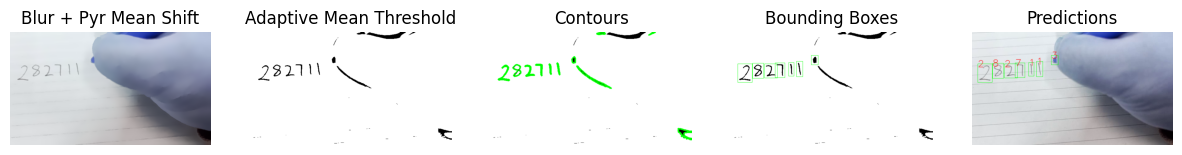

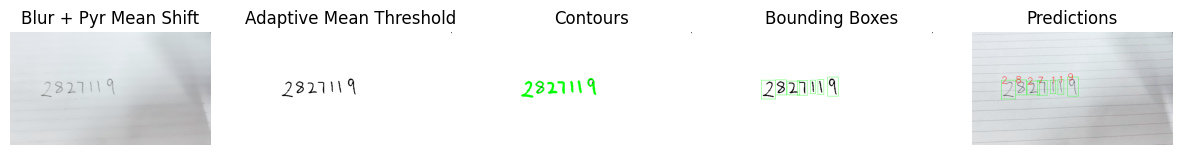

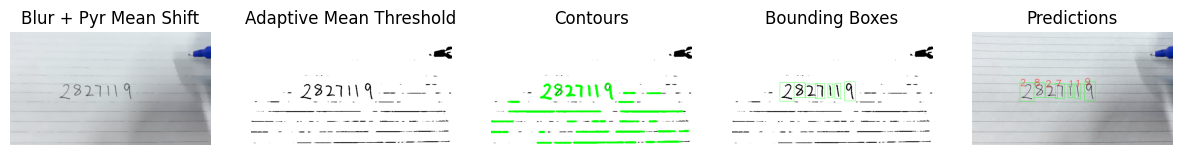

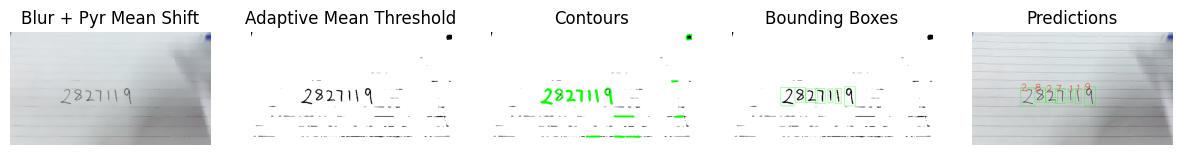

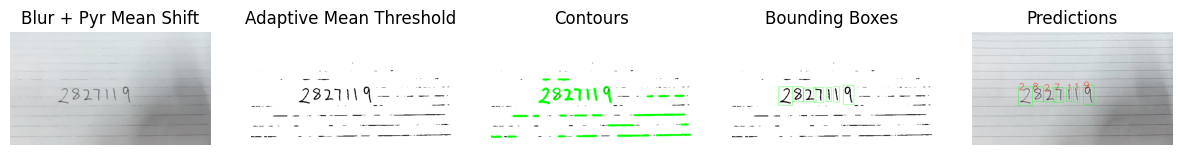

In [ ]:
# Gets a every 15 frames of the video to show how the segmentation works visually
every15Frames = [frames[i] for i in range(0, len(frames), 15)]

# Displays the segmentation process for each frame in the array
for f in every15Frames:
  ProccessVideoFrameWithVisuals(f)

In [ ]:
def ProccessVideoFrame(image):
  # Same code as above without visuals

  frameBlurred = cv2.GaussianBlur(image, (3, 3), 2)

  frameMeanShifted = cv2.pyrMeanShiftFiltering(frameBlurred, 9, 20)

  frameMeanShiftedG = BGR2GRAY(frameMeanShifted)

  frameMeanAdaptive = cv2.adaptiveThreshold(frameMeanShiftedG, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 75, 20)

  frameConts = FindContours(frameMeanAdaptive, 0, 10, 25.0, 550.0)

  frameBoundingBoxes = FindBoundingBoxes(frameConts, 10)

  frameSegments = CropBoundingBoxes(frameMeanAdaptive, frameBoundingBoxes)

  if len(frameSegments) < 1:
    return image

  frameSegmentsBitwised = [BitwiseImage(image, 10) for image in frameSegments]
  frameSegmentsinverted = [cv2.bitwise_not(image) for image in frameSegmentsBitwised]

  frameSegmentsSquare = [MakeImageSquareAndResize(image, 2) for image in frameSegmentsinverted]
  frameSegmentsSquareMorphed = [MorphImage(image, 2, cv2.MORPH_CLOSE, 1) for image in frameSegmentsSquare]

  framePredictions, frameConfidences = PredictImages(np.array(frameSegmentsSquareMorphed), model)

  frameWithPredictions = DrawPredictions(image, framePredictions, frameBoundingBoxes, frameConfidences, 0.0, lineThickness=1, fontThickness=1, fontSize=1)

  return frameWithPredictions

In [ ]:
# Run the frame segmentation on all frames and output into video
finalVideo = []
for frame in frames:
  frameWithPredictions = ProccessVideoFrame(frame)
  finalVideo.append(frameWithPredictions)

out = cv2.VideoWriter('./OutputVideo.avi',cv2.VideoWriter_fourcc(*'XVID'), 24, (640, 360), True)

for frame in finalVideo:
    out.write(frame)
out.release()